<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [ ]:
#@title Current Date
Today = '2021-10-05' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [71]:
# standard libraries
import re
import pandas as pd
import numpy as np
import pymc3 as pm
import os

# SKlearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_log_error,
    mean_absolute_percentage_error,
    classification_report,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek


# NLP libraries
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

# For plotting
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import jupyterthemes.jtplot as jt

# jt.style(theme="monokai")
random_state = 188245
np.random.seed(random_state)

%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Loading and preparing training data

In [91]:
dir_path = os.path.join(os.getcwd(), "house_prices")
train_fname = "HousePrice_Train.csv"
test_fname = "HousePrice_Test.csv"

train_set = (
    pd.read_csv(os.path.join(dir_path, train_fname),)
    .rename(columns=lambda x: x.lower())
    .set_index("index")
    .drop(columns="id")
)
print("Loaded training set of shape", train_set.shape)


test_set = (
    pd.read_csv(os.path.join(dir_path, test_fname),)
    .rename(columns=lambda x: x.lower())
    .set_index("index")
    .drop(columns="id")
)
print("Loaded training set of shape", test_set.shape)

Loaded training set of shape (1638, 12)
Loaded training set of shape (702, 11)


### Examining missing data
Check the number of missing entries in the training set

In [3]:
train_set.isna().sum()

location            0
num_bathrooms       0
num_beds            0
ber_class         251
description         0
services         1061
features            0
latitude            0
longitude           0
type                0
surface             0
price               0
dtype: int64

While the above shows we don't have many missing values, this is actually incorrect! The text columns have entries with "None" as strings instead of `None`, we need to replace these. 

I'll also drop `location` as this will already be represented by the `latitude` and `longitude` features

In [4]:
string_features = train_set.select_dtypes("object").copy()
string_features = string_features.where(string_features != "None", None)

train_set.drop(columns=string_features.columns, inplace=True)
train_set = pd.concat([train_set, string_features], axis=1).drop(columns="location")
train_set.isna().sum()

num_bathrooms       0
num_beds            0
latitude            0
longitude           0
surface             0
price               0
ber_class         251
description         0
services         1061
features          516
type                0
dtype: int64

## Examining outliers
Next let's try to identify outliers.

Numeric columns: ['num_bathrooms', 'num_beds', 'latitude', 'longitude', 'surface', 'price']


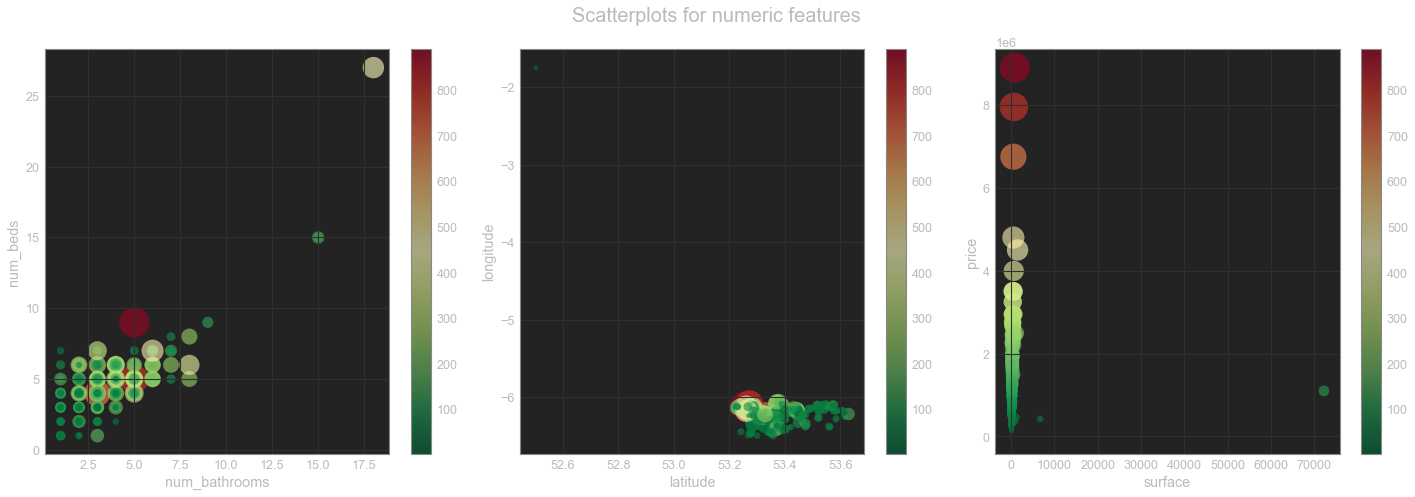

In [5]:
def plot_numeric_feats(dataset, cmap=get_cmap("RdYlGn").reversed()):
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    scaled_price = dataset["price"] / 10_000

    dataset[["num_bathrooms", "num_beds", "price"]].plot.scatter(
        "num_bathrooms",
        "num_beds",
        s=scaled_price,
        ax=axes[0],
        alpha=0.6,
        c=scaled_price,
        cmap=cmap,
    )
    dataset[["latitude", "longitude", "price"]].plot.scatter(
        "latitude",
        "longitude",
        s=scaled_price,
        ax=axes[1],
        alpha=0.6,
        c=scaled_price,
        cmap=cmap,
    )
    dataset[["surface", "price"]].plot.scatter(
        "surface",
        "price",
        s=scaled_price,
        ax=axes[2],
        alpha=0.6,
        c=scaled_price,
        cmap=cmap,
    )
    fig.suptitle("Scatterplots for numeric features", size=20)
    fig.tight_layout()
    plt.show()


print("Numeric columns:", train_set.select_dtypes(["int", "float"]).columns.tolist())
plot_numeric_feats(train_set)

THe scatterplots indicate the presences of a few outliers in the numeric features, let's examine them

In [6]:
bathroom_mask = train_set["num_bathrooms"] > 10
longitude_mask = train_set["longitude"] > -5
surface_mask = train_set["surface"] > 5_000

train_set_outliers = train_set[bathroom_mask | longitude_mask | surface_mask]
pd.set_option("max_colwidth", 200)
train_set_outliers.drop(columns=["services"])

,num_bathrooms,num_beds,latitude,longitude,surface,price,ber_class,description,features,type
index,,,,,,,,,,
356,1,3,52.501856,-1.744995,79.00000,199000,NaN,"RAY COOKE AUCTIONEERS take great pleasure in introducing this stunning three bedroom semi-detached family home to the market on Wheatfield Close, Dublin 22. \n\nThis ever sought after location is ...",None,semi-detached
507,1,4,53.474502,-6.343483,72236.38714,1100000,E1,Thornton Park is a superb modern equestrian centre offering top class facilities in a beautiful setting on approximately 17.85 acres located 25 minutes from Dublin s City Centre.\n\nThe state of t...,None,bungalow
558,15,15,53.335109,-6.331515,318.20000,775000,D1,"umber 67 &amp; 69 Jamestown Road represent a fantastic investment opportunity to the discerning investor bringing a previous rent roll of €106,600 which can be improved upon. Ideally located on a ...","18 separate units\nTransport links including the LUAS\nStriking distance of the city centre\nRent roll €106,600\nIn the heart of the village\nLane access\n",semi-detached
1100,15,15,53.287504,-6.146605,700.00000,1500000,NaN,A truly unique stone built house of great quality totalling approx. 700 sq.m/7534 sq.ft steeped in history and built on the original lands of Monkstown Castle in 1859 for the honourable J.W Vesey ...,Lift servicing all floors\nVenetian and gothic influences throughout\nArchitect designed by Dean and Woodward in 1858\nUsed previously both as a guest house and a nursing home\nAmple off street pa...,detached
1116,1,2,53.386540,-6.377356,6705.00000,425000,E2,"Baxter Real Estate are delighted to present to the market, this detached bungalow located on Main Street, Blanchardstown. Most recently used as a dental surgery, this property extends to approxima...","Short drive to the N3 and M50 .\nSuitable for residential use, subject to planing permission.\nWithin walking distance of Blanchardstown Shopping Centre and beside Supervalu Blanchardstown.\nDetac...",bungalow
1379,18,27,53.260955,-6.117266,1490.00000,4500000,NaN,The Grove is an imposing Victorian mansion built c.1840 situated on approximately 0.88 ha / 2.17 acres of mature elevated grounds with outstanding sea views across Killiney Bay. With accommodation...,Approx. 1 490 sq. m / 16 041 sq. ft. of accommodation over four floors\nSituated on mature grounds of approximately 0.88 ha / 2.17 acres\nAbundance of period features\nOutstanding sea views across...,detached


### Outlier analysis
- index 356 : Has incorrect latitude. A google maps search shows this location is in Birmingham, UK
- index 507 : Is not a house but an equestrian centre with 17 acres
- index 558 : 15 beds and bathrooms shows that is actually a number of units
- index 1100 : Is actually fine, the house is just a big mansion.
- index 1116 : Incorrect value for surface, the description shows it is 67.5sqm
- index 1379 : Another mansion

Overall the first three entries could be removed from the dataset for showing poor data quality and `index 1116` can be fixed manually. 

The only decision lies within leaving the two ads for mansions in the dataset or not. The scatterplot above shows that these mansions have an abnormal number of bathrooms/bedrooms when compared with the rest of the houses, hence I'll choose to remove them

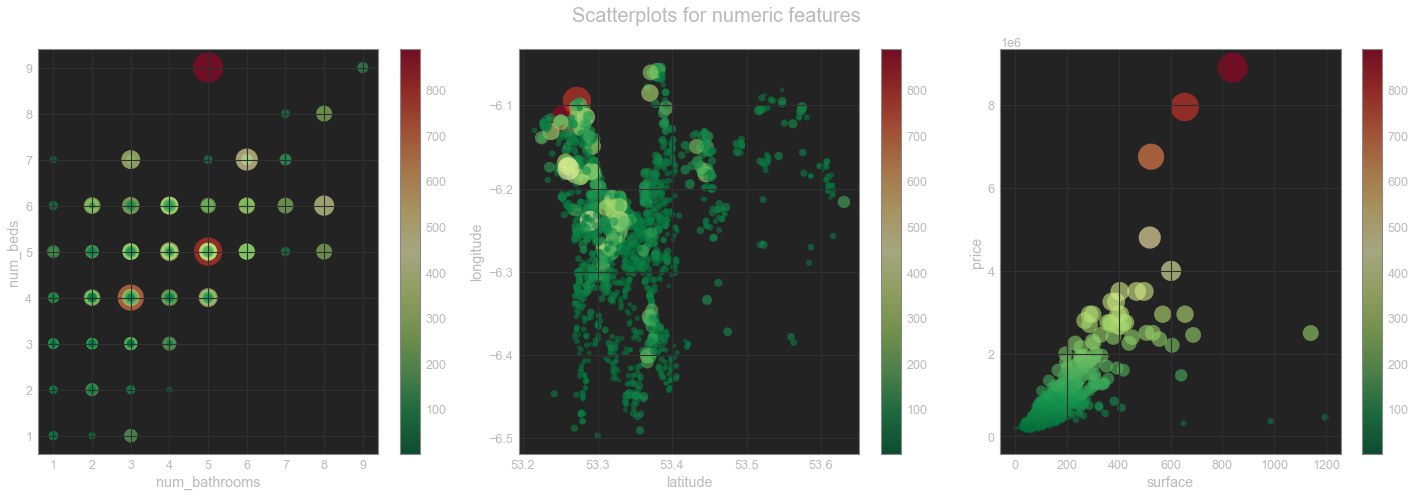

In [7]:
pd.reset_option("max_colwidth")

drop_index = [356, 507, 558, 1100, 1379]
fix_index = 1116

cleaned_train_set = train_set.drop(index=drop_index)
cleaned_train_set.loc[fix_index, "surface"] = (
    cleaned_train_set.loc[fix_index, "surface"] / 100
)
plot_numeric_feats(cleaned_train_set)

Now the datapoints look much better distributed, let's do some more feature selection

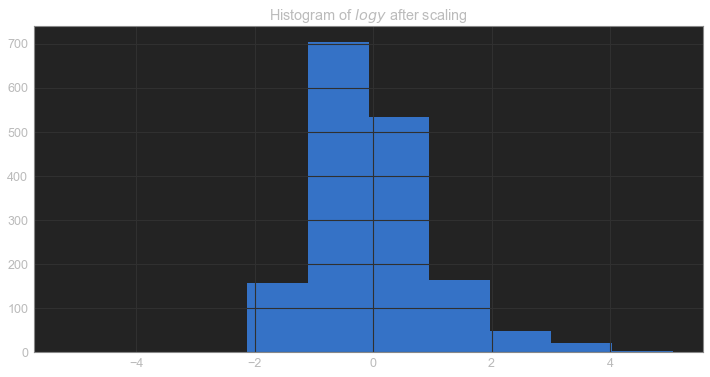

In [8]:
X, y = cleaned_train_set.drop(columns="price"), cleaned_train_set["price"]

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(np.log(y.values.reshape(-1, 1)))

plt.figure(figsize=(12, 6))
plt.title("Histogram of $log{y}$ after scaling")
plt.hist(y_scaled)
plt.show()

In [9]:
X_numeric = X.select_dtypes(["int", "float"])

feature_scaler = StandardScaler()
X_num_scaled = feature_scaler.fit_transform(X_numeric)

# Baseline model
Let's set some baseline models that predict mean and median house price so we have a start point for our more advanced models

In [126]:
def print_evaluation(y, y_preds, model_name="Baseline Mean"):
    mae = mean_absolute_error(y, y_preds)
    msle = mean_squared_log_error(y, y_preds)
    rmsle = np.sqrt(msle)
    mape = mean_absolute_percentage_error(y, y_preds)

    print(f"------ {model_name} model performance ------")
    print(f"MAE: {mae:,.2f}")
    print(f"MSLE: {msle:,.4f}")
    print(f"RMSLE: {rmsle:,.4f}")
    print(f"MAPE: {mape:,.4f}")


def baseline_mean(y, y_scaler, evaluate=True):
    """Creates a set of predictions for X using solely the mean of training samples"""
    y_true = np.exp(y_scaler.inverse_transform(y))
    y_preds = np.exp(y_scaler.inverse_transform(np.ones(shape=(y.shape)) * np.mean(y)))

    if evaluate:
        print_evaluation(y_true, y_preds)
    return y_preds


def baseline_median(y, y_scaler, evaluate=True):
    """Creates a set of predictions for X using solely the median of training samples"""
    y_true = np.exp(y_scaler.inverse_transform(y))
    y_preds = np.exp(
        y_scaler.inverse_transform(np.ones(shape=(y.shape)) * np.median(y))
    )

    if evaluate:
        print_evaluation(y_true, y_preds)
    return y_preds

In [12]:
train_price = cleaned_train_set["price"].to_numpy().reshape(-1, 1)

y_train_mean = baseline_mean(y_scaled, y_scaler)
y_train_median = baseline_median(y_scaled, y_scaler, "Baseline median")

------ Baseline Mean model performance ------
MAE: 263,449.64
MSLE: 0.35
RMSLE: 0.59
MAPE: 0.47
------ Baseline Mean model performance ------
MAE: 260,487.51
MSLE: 0.36
RMSLE: 0.60
MAPE: 0.41


Create a dummy submission using these models

In [13]:
test_set = pd.read_csv(os.path.join(dir_path, test_fname))
copy = test_set.copy()

y_test_mean_preds = y_train_mean[: test_set.shape[0]]
y_test_median_preds = y_train_median[: test_set.shape[0]]

copy["Price"] = y_test_mean_preds
copy[["Index", "Price"]].to_csv(
    os.path.join(dir_path, "preds/", "mean_preds.csv"), index=False
)
copy["Price"] = y_test_mean_preds
copy[["Index", "Price"]].to_csv(
    os.path.join(dir_path, "preds/", "median_preds.csv"), index=False
)

As expected horrible, but now we have something we can improve on

# NATURAL LANGUAGE PROCESSING

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

Let's now examine text features. We already know that `ber_class` and `type` can be encoded so let's separate them.

In [14]:
encoding_features = ["ber_class", "type"]

X_txt = X.select_dtypes("object")
X_txt.sample(5, random_state=random_state)

,ber_class,description,services,features,type
index,,,,,
1412,C1,BRACKEN ESTATES 01 4966444 are delighted to br...,"Parking,Gas Fired Central Heating,Alarm,Wired ...",Extending to approx. 197 square metres\nBeauti...,townhouse
1536,E1,Mason Estates present this spacious four bedro...,NaN,Property offers great potential \nBright spaci...,semi-detached
541,NaN,RAY COOKE AUCTIONEERS are delighted to present...,NaN,None,terraced
231,C1,Horan Estate &amp; Letting Agents are delighte...,Parking,Within drive distance to Omni Shopping Centre\...,apartment
562,C3,DNG are delighted to present to the market an ...,"Parking,Gas Fired Central Heating,Alarm",2 bed ground floor own door apartment c.78.75s...,apartment


There are some characters that need to be cleaned from `description` and `features`, let's remove `\n`, `\r` and variants

In [15]:
def clean_texts(series):
    """Cleans linebreaks, tabs return character, punctuation and double spacing in a Series of strings."""
    clean_series = series.copy().str.replace(r"\t|\n|\r", " ", regex=True)
    clean_series = clean_series.str.replace(r"[,.?!:;\[\]/\(\)'\"]", " ", regex=True)
    clean_series = clean_series.str.replace(r"\s+", " ", regex=True)
    return clean_series.str.lower()


def map_ber(series):
    """Removes the numerical rating for BER, yielding only the letter rating.

    I'm trying this strategy as class A1 has only one sample, which doesn't allow for 
    upsampling with SMOTE. In addition, using only a letter rating yields a smaller number
    of classes and can make the problem of estimating new BER classes easier
    """
    clean_ber = series.str.replace("SINo666of2006exempt", "EX")
    clean_ber = clean_ber.str.replace(r"\d+", "", regex=True)
    return clean_ber

In [16]:
X_txt.loc[:, "description"] = clean_texts(X_txt.loc[:, "description"])
X_txt.loc[:, "features"] = clean_texts(X_txt.loc[:, "features"])
X_txt.loc[:, "ber_class"] = map_ber(X_txt.loc[:, "ber_class"])

X_txt[["description", "features", "ber_class"]].sample(3, random_state=random_state)

C:\Users\gamin\anaconda3\envs\et5003\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,description,features,ber_class
index,,,
1412,bracken estates 01 4966444 are delighted to br...,extending to approx 197 square metres beautifu...,C
1536,mason estates present this spacious four bedro...,property offers great potential bright spaciou...,E
541,ray cooke auctioneers are delighted to present...,None,NaN


In [17]:
X_txt.isna().sum()

ber_class       248
description       0
services       1058
features        514
type              0
dtype: int64

`ber_class` and `services` have many null entries, but perhaps we can use other features to estimate `ber_class`?

First we isolate the instances that have missing values and preprocess the training data by vectorizing and upsampling the targe classes

In [43]:
# Let's separate entries where ber_class is missing, we want to fill these in
missing_ber = X_txt["ber_class"].isna()
X_missing = X_txt.loc[missing_ber, "description"].copy()

X_ber = X_txt.loc[~missing_ber, "description"].copy()
y_ber = X_txt.loc[~missing_ber, "ber_class"].copy()

label_encoder = LabelEncoder()
y_ber_encoded = label_encoder.fit_transform(y_ber)

vectorizer = TfidfVectorizer()
X_ber_vec = vectorizer.fit_transform(X_ber)

smote = SMOTETomek(random_state=random_state)
X_ber_bal, y_ber_bal = smote.fit_resample(X_ber_vec, y_ber_encoded)

X_ber_train, X_ber_test, y_ber_train, y_ber_test = train_test_split(
    X_ber_bal, y_ber_bal, train_size=0.85, random_state=random_state,
)
print(f"BER training set shape: {X_ber_train.shape}")
print(f"BER test set shape: {X_ber_test.shape}")

BER training set shape: (2903, 11102)
BER test set shape: (513, 11102)


Now let's use grid search to find the best model for this task.

In [46]:
pipeline = Pipeline([("model", RandomForestClassifier(random_state=random_state)),])

param_grid = [
    {
        "model": [RandomForestClassifier()],
        "model__random_state": [random_state],
        "model__n_estimators": range(107, 115, 1),
        "model__max_depth": range(37, 42),
    },
    {
        "model": [SVC()],
        "model__random_state": [random_state],
        "model__C": np.arange(0.95, 1.15, 0.1),
        "model__kernel": ["poly", "rbf"],
        "model__degree": [2, 3],
        "model__gamma": ["scale"],
    },
]
grid_search = GridSearchCV(
    pipeline, param_grid, scoring="accuracy", cv=3, verbose=3, n_jobs=-1
)
grid_search.fit(X_ber_train, y_ber_train)
best_clf = grid_search.best_estimator_
print(best_clf)

y_ber_preds = best_clf.predict(X_ber_test)
print(
    classification_report(
        y_ber_test, y_ber_preds, zero_division=0, target_names=label_encoder.classes_
    )
)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Pipeline(steps=[('model',
                 SVC(C=1.05, degree=2, kernel='poly', random_state=188245))])
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        69
           B       0.90      0.98      0.94        54
           C       0.56      0.58      0.57        62
           D       0.58      0.58      0.58        67
           E       0.85      0.74      0.79        68
          EX       1.00      1.00      1.00        51
           F       1.00      1.00      1.00        71
           G       0.93      0.96      0.94        71

    accuracy                           0.85       513
   macro avg       0.85      0.85      0.85       513
weighted avg       0.85      0.85      0.85       513



We found a model with decent enough accuracy, let's use this to fill in the missing values now

In [70]:
missing_preds = label_encoder.inverse_transform(
    best_clf.predict(vectorizer.transform(X_missing.copy()))
)
X_txt.loc[missing_ber, "ber_class"] = missing_preds

print(f"There are {X_txt['ber_class'].isna().sum()} missing BER values")

There are 0 missing BER values


C:\Users\gamin\anaconda3\envs\et5003\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\gamin\anaconda3\envs\et5003\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


## Encoding text variables
Now we have all values for BER filled in, we can encode `ber_class` and `type` as features to use for regression

In [84]:
# Property maps as defined by Nigel Portley
property_type_mapper = {
    "studio": 0,
    "apartment": 1,
    "duplex": 2,
    "site": 3,
    "terraced": 4,
    "bungalow": 5,
    "end-of-terrace": 6,
    "townhouse": 7,
    "semi-detached": 8,
    "detached": 9,
}

ber_encoder = OrdinalEncoder(dtype="int")

X_txt_features = X_txt[["ber_class", "type"]].copy()
X_txt_features["ber_class"] = ber_encoder.fit_transform(
    X_txt_features["ber_class"].to_numpy().reshape(-1, 1)
)
X_txt_features["type"] = X_txt_features["type"].map(property_type_mapper)

X_txt_features

,ber_class,type
index,,
1,2,1
2,3,4
3,0,8
4,4,9
5,3,9
...,...,...
1634,2,5
1635,2,9
1636,0,8


# Create train/validation set

The validation set will be used to fine-tune the models

In [85]:
X_train_full = np.c_[X_num_scaled, X_txt_features.to_numpy()]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_scaled, test_size=0.3, random_state=random_state
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

X_train shape: (1143, 7)
X_valid shape: (490, 7)


In [94]:
# Leaving this in to test model results with just numeric features

X_train_num, X_valid_num, y_train_num, y_valid_num = train_test_split(
    X_num_scaled, y_scaled, test_size=0.3, random_state=random_state
)

print("X_train_num shape:", X_train_num.shape)
print("X_valid_num shape:", X_valid_num.shape)

X_train_num shape: (1143, 5)
X_valid_num shape: (490, 5)


## Preparing the test set

I'll also implement a function to prepare the test data so we can generate predictions and test them on Kaggle

In [127]:
import warnings


def prepare_test_set(
    test_fname="HousePrice_Test.csv",
    dir_path=dir_path,
    feature_scaler=feature_scaler,
    vectorizer=vectorizer,
    ber_model=best_clf,
    ber_encoder=ber_encoder,
    property_type_mapper=property_type_mapper,
    feature_cols=[
        "num_bathrooms",
        "num_beds",
        "latitude",
        "longitude",
        "surface",
        "ber_class",
        "description",
        "type",
    ],
):
    """Implements a series of preprocessing methods on the test set"""
    warnings.filterwarnings("ignore")

    test_set = (
        pd.read_csv(os.path.join(dir_path, test_fname))
        .rename(columns=lambda x: x.lower())
        .set_index("index")
        .drop(columns="id")
        .loc[:, feature_cols]
    )
    print("Loaded training set of shape", test_set.shape)

    X_num = test_set.select_dtypes(["int", "float"])
    print("Scaling numeric columns:", " - ".join(X_num.columns))
    X_num_scaled = feature_scaler.transform(X_num.to_numpy())

    X_txt = test_set.select_dtypes("object")
    print("Preprocessing text columns:", " - ".join(X_txt.columns))
    X_txt.loc[:, "description"] = clean_texts(X_txt.loc[:, "description"])
    X_txt.loc[:, "ber_class"] = map_ber(X_txt.loc[:, "ber_class"])

    missing_ber = X_txt["ber_class"].isna()
    if missing_ber.sum() > 0:
        print(
            f"\tfound {missing_ber.sum()} entries with missing BER class, using ber_model to fill in values"
        )
        missing_preds = label_encoder.inverse_transform(
            ber_model.predict(
                vectorizer.transform(X_txt.loc[missing_ber, "description"].copy())
            )
        )
        X_txt.loc[missing_ber, "ber_class"] = missing_preds
    print(f"Encoding text features")
    X_txt_features = X_txt[["ber_class", "type"]].copy()
    X_txt_features["ber_class"] = ber_encoder.transform(
        X_txt_features["ber_class"].to_numpy().reshape(-1, 1)
    )
    X_txt_features["type"] = X_txt_features["type"].map(property_type_mapper)

    X_test = np.c_[X_num_scaled, X_txt_features.to_numpy()]
    print(f"Generated final test set of shape {X_test.shape}")
    warnings.resetwarnings()

    return test_set.index, X_test

In [128]:
test_indexes, X_test = prepare_test_set()

Loaded training set of shape (702, 8)
Scaling numeric columns: num_bathrooms - num_beds - latitude - longitude - surface
Preprocessing text columns: ber_class - description - type
	found 108 entries with missing BER class, using ber_model to fill in values
Encoding text features
Generated final test set of shape (702, 7)


# Full Regression

In [86]:
def define_lin_reg(
    predictors,
    observed,
    n_iterations=30_000,
    n_samples=5_000,
    alpha=("Normal", 0, 10),
    beta=("Normal", 0, 10),
    sigma=("HalfCauchy", 5),
):
    """Defines and trains a Bayesian linear regression model:
            mu ~ alpha + beta * predictors
    With likelihood
            likelihood ~ N(mu, sigma)
    Where alpha, beta and sigma are pymc distributions defined by the user.

    Parameters
    ----------
    predictors : np.ndarray
        Numpy array with model features.
    observed : np.ndarray
        Numpy array with observed values of the target feature. Preferably as a 1-D array
        to speed up fitting time.
    n_iterations : int
        The number of iterations for fitting.
    n_samples : int
        The number of samples to draw for the posterior.
    alpha : tuple(string, int, [int, ])
        Prior distribution of alpha. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.
    beta : tuple(string, int, [int, ])
        Prior distribution of beta. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.
    sigma : tuple(string, int, [int, ])
        Prior distribution of sigma. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.

    Returns
    -------
    posterior : pymc3.backends.base.MultiTrace
        Posterior distribution estimated by pymc model.
    """

    with pm.Model() as model:
        alpha = getattr(pm, alpha[0])("alpha", *alpha[1:])
        beta = getattr(pm, beta[0])("beta", *beta[1:], shape=predictors.shape[1])

        mu = alpha + pm.math.dot(beta, predictors.T)

        sigma = getattr(pm, sigma[0])("sigma", *sigma[1:])
        likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=observed)
        approximation = pm.fit(n_iterations, method="advi", random_seed=random_state)
        posterior = approximation.sample(n_samples)
    return posterior


def predict(posterior, X, y_scaler):
    """Calculates the predictions for a given X based on a learned posterior
    
    Parameters
    ----------
    posterior : pymc3.backends.base.MultiTrace.
        Posterior distribution estimated by pymc model.
    X : np.ndarray
        Input features of data to estimate.
    y_scaler : sklearn.preprocessing._data.StandardScaler
        Scaler used to transform the predictor variable.
    Returns
    -------
    np.ndarray
        The model predictions.
    """
    log_likelihood = np.mean(posterior["alpha"]) + np.dot(
        np.mean(posterior["beta"], axis=0), X.T
    )
    y_pred = np.exp(y_scaler.inverse_transform(log_likelihood.reshape(-1, 1)))
    return y_pred

In [141]:
full_model = define_lin_reg(
    X_train_num,
    y_train_num.ravel(),
    alpha=("Normal", 0, 100),
    beta=("Normal", 0, 100),
    sigma=("HalfCauchy", 30),
)

y_train_preds = predict(full_model, X_train_num, y_scaler,)
print_evaluation(
    np.exp(y_scaler.inverse_transform(y_train_num)),
    y_train_preds,
    "(numeric features) Full Bayesian",
)

y_valid_preds = predict(full_model, X_valid_num, y_scaler,)
print_evaluation(
    np.exp(y_scaler.inverse_transform(y_valid_num)),
    y_valid_preds,
    "(validation) Full Bayesian",
)

test_pred_df = (
    pd.DataFrame(
        predict(full_model, X_test[:, :-2], y_scaler), # Remove the last two columns for the numeric bayesian model
        index=test_indexes,
        columns=["Price"],
    )
    .reset_index()
    .rename({"index": "Index"})
)
test_pred_df.to_csv(
    os.path.join(dir_path, "preds/", "numeric_bayesian_preds.csv"), index=False
)

C:\Users\gamin\anaconda3\envs\et5003\lib\site-packages\theano\tensor\basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex(data)  # works for all numeric scalars


Finished [100%]: Average Loss = 994.69
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 994.69


------ (numeric features) Full Bayesian model performance ------
MAE: 163,644.96
MSLE: 0.1056
RMSLE: 0.3250
MAPE: 0.2550
------ (validation) Full Bayesian model performance ------
MAE: 154,867.00
MSLE: 0.1032
RMSLE: 0.3213
MAPE: 0.2693


In [142]:
full_model = define_lin_reg(
    X_train,
    y_train.ravel(),
    alpha=("Normal", 0, 100),
    beta=("Normal", 0, 100),
    sigma=("HalfCauchy", 30),
)

y_train_preds = predict(full_model, X_train, y_scaler,)
print_evaluation(
    np.exp(y_scaler.inverse_transform(y_train)),
    y_train_preds,
    "(num+txt features) Full Bayesian",
)

y_valid_preds = predict(full_model, X_valid, y_scaler,)
print_evaluation(
    np.exp(y_scaler.inverse_transform(y_valid)),
    y_valid_preds,
    "(validation) Full Bayesian",
)

test_pred_df = (
    pd.DataFrame(
        predict(full_model, X_test, y_scaler), index=test_indexes, columns=["Price"]
    )
    .reset_index()
    .rename({"index": "Index"})
)
test_pred_df.to_csv(
    os.path.join(dir_path, "preds/", "num_txt_bayesian_preds.csv"), index=False
)

C:\Users\gamin\anaconda3\envs\et5003\lib\site-packages\theano\tensor\basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex(data)  # works for all numeric scalars


Finished [100%]: Average Loss = 1,005.3
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 1,005.3


------ (num+txt features) Full Bayesian model performance ------
MAE: 158,674.86
MSLE: 0.1023
RMSLE: 0.3199
MAPE: 0.2462
------ (validation) Full Bayesian model performance ------
MAE: 154,269.78
MSLE: 0.1034
RMSLE: 0.3216
MAPE: 0.2660


The text features add a small improvement.

# PIECEWISE REGRESSION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

Your comments, explanation, and references here.

In [ ]:
from sklearn.mixture import GaussianMixture



# BAYESIAN NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

Your comments, explanation, and references here.

In [ ]:
# your code here

# SUMMARY

Your summary here.